In [2]:
import json
import copy
from IPython.display import display, Javascript, HTML, clear_output
from ipywidgets import widgets, Output, interact, fixed, Layout
from ipywidgets.widgets import Dropdown, interactive_output, VBox, HBox, interactive, FloatText
from datetime import datetime, timedelta
from urllib.parse import quote_plus
from utils.notebooks import get_date_slider_from_datetime, get_next_notebook, get_previous_notebook

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}

.widget-radio-box{
    flex-direction: row;
}

.widget-radio-box input{
    margin:0 6px 0 5px
}
</style>

In [4]:
%%capture
## Some Extensions ##
%load_ext autoreload
%autoreload 2
%store -r the_page

if 'the_page' not in locals():
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output
from datetime import date
import urllib

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from external.wikimedia import WikiMediaDV, WikiMediaAPI
from external.xtools import XtoolsAPI, XtoolsDV

# Data Processing
import pickle
import pandas as pd
import numpy as np

# Visualization tools
import qgrid
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots

# Page views timeline
from visualization.views_listener import ViewsListener

# Change actions timeline
from visualization.actions_listener import ActionsListener

# Actions per editor visualization
from visualization.editors_listener import EditorsListener
from visualization.editors_listener import RankedEditorsListener

# Conflicts visualization
from visualization.conflicts_listener import ConflictsListener, ConflictsActionListener, ConflictsEditorListener
from visualization.calculator_listener import ConflictCalculatorListener

# Word cloud visualization
from visualization.wordcloud_listener import WCListener, WCActionsListener
from visualization.wordclouder import WordClouder

# Tokens per revision visualization
from visualization.tokens_listener import TokensListener, TokensOwnedListener

# Wikipedia talk pages visualization
from visualization.talks_listener import TalksListener
from visualization.topics_listener import TopicsListener

# Tokens ownership visualization
from visualization.owned_listener import OwnedListener

# Metrics management
from metrics.conflict import ConflictManager
from metrics.token import TokensManager

# For language selection
from utils.lngselection import abbreviation, lng_listener

In [6]:
# the method that listens to the click event
def on_button_clicked(b):
    global the_page, the_talk_page
    
    # use the out widget so the output is overwritten when two or more
    # searches are performed
    with out0:
        try:
            # query wikipedia
            wikipedia_dv = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
            search_result = wikipedia_dv.search_page(searchTerm.value)
            the_page = wikipedia_dv.get_page(search_result)
            the_talk_page = wikipedia_dv.get_page("Talk:"+search_result)
            %store the_page
            clear_output()
            display(md(f"The page that was found: **{the_page['title']}**"))
            display(md(f"Page id: **{the_page['page_id']}**"))

        except:
            clear_output()
            display(md(f'The page title *"{searchTerm.value}"* was not found'))

# Load the selection from NB1
with open('utils/language.json', 'r') as file:
    json_selection = json.load(file)
    lng_nb1 = json_selection['lng']
    title_nb1 = json_selection['search_term']

# Language selection.
languageSelection = Dropdown(options=['English', 'Deutsch', 'Español', 'Türkçe', 'Euskara'], value=lng_nb1, description='Language:')            

# by default display the last search
try:
    searchTerm = widgets.Text(the_page['title'], description='Page title:')
except:
    searchTerm = widgets.Text(title_nb1, description='Page title:')

second_select = widgets.interactive(lng_listener, lng=languageSelection, search_term=searchTerm)
display(second_select.children[0])
display(second_select.children[1])

# create and display the button    
button = widgets.Button(description="Search")
display(button)

# the output widget is used to remove the output after the search field
out0 = Output()
display(out0)

# set the event
button.on_click(on_button_clicked)

# trigger the event with the default value
on_button_clicked(button)

Dropdown(description='Language:', options=('English', 'Deutsch', 'Español', 'Türkçe', 'Euskara'), value='Engli…

Text(value='The Camp of the Saints', description='Page title:')

Button(description='Search', style=ButtonStyle())

Output()

If you have input another page title and still want to use these variables in the next 4 notebooks, please refresh!

In [7]:
def restart_and_run():
    display(HTML(
        '''
            <script>
                code_show = false;
                function restart_run_all(){
                    IPython.notebook.kernel.restart();
                    setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    })
                }
            </script>
            <button onclick="restart_run_all()">Refresh All Variables</button>
        '''
    ))
restart_and_run()

---

# A. Change actions and their impact

**The dynamics of individual changes** to each word (and each special character) in the article are extracted by the [WikiWho API](https://www.wikiwho.net/en/api/v1.0.0-beta/). 

Below, you find several metrics for such change dynamics such as unsucessful/reverted changes and conflict. 

<br>
<details>    
    <summary style="cursor: pointer;font-weight:bold">More information about WikiWho's method</summary>


The [WikiWho API](https://www.wikiwho.net/en/api/v1.0.0-beta/) tracks the changes to every token (words or special characters) on a Wikipedia page with at least 95% accuracy, for live Wikipedia articles. It distinguishes every token in the document even when the string appears several times. E.g. "and" at the beginning of an article is a different token then "and" at the end of the article. See also [this figure](https://www.wikiwho.net/#technical_details).

That means that *not only edits* (== whole revisions) are counted, which can contain changes of many different tokens, but *every single action to every single token* is recorded. 
 <br>   
   The two most basic actions that can perfomed per token are **insertions** and **deletions**. A character change in a word, e.g. "dog" -> "dogs", is modeled as deletion of "dog" and the insertion of "dogs", two separate tokens.
 <br>   
    An **insertion** is also considered a **re-insertion** if the insertion has occured before; the only insertion of a token that is not a re-insertion is the first one (original addition of the token). Similarly, a **deletion** is also considered a **re-deletion** if the deletion has occured before.

Formally, the token history can represented by a time-ordered sequence of actions 
*(a<sub>0</sub>, ..., a<sub>n</sub>)*; note that *a<sub>0+2i</sub>* is always an insertion and 
*a<sub>1+2i</sub>* is always a deletion for i ∈ ℕ.
</details> 


---

*IMPORTANT:* For articles with a long revision history, please allow for some time to load, 
before interacting with the controls too often.

## A.1 Actions over time - When did certain change actions happen?

In the following graph you can
* select the *date range* and *granularity* (yearly, monthly) of the timeline (X-axis), and 
* plot any of the following *change action types* in the black, red, blue and green lines. 

<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Explanation of the change action types</summary>

   
- **adds**: number of first-time insertions / additions
- **adds_surv_48h**: number of adds that survived at least 48 hours (after 48h, the risk of being removed is negligible on avg.)
- **adds_stopword_count**:  number of insertions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
<br>

- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours 
- **dels_stopword_count**: number of deletions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
<br>

- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertions that survived at least 48 hours
- **reins_stopword_count**: number of reinsertions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
</details>
<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Example</summary>

For instance, if you see 10 "adds" in a month, but only 4 "adds_surv_48h", 10 completely new tokens/words have been added to the article, but only 4 of them stayed in the article for more than 2 days, which usually means the other 6 are gone for good. If "dels" are performed and don't survive, that means that these deletions have been undone, i.e., the deleted tokens have been put back. I.e., these are measurements of the longevity and stability of edit actions done to the article.
</details>
<br>

<details>    
    <summary style="cursor: pointer;font-weight:bold">Conflicts</summary>

Our measurement of ***conflict*** for single tokens is taken from [Flöck et al.](https://arxiv.org/abs/1703.08244):


* (1)  The main idea is to count how often a token  - after being created (added) the first time -  was being deleted, re-inserted, re-deleted, re-inserted, and so on; which would often happen in case two editors disagree on the token's justification to be in the text. 
* (2) Only the **re-**deletions and **re-**insertions are counted, since up to the first delete it could be a simple correction that didn't trigger a reponse - this wouldn't indicate conflict. 
* (3) The **"re-"** actions are only counted if they alternate between different editors and don't come from the same editor twice or more in a row - as the latter would simply indicate self-corrections. 
* (4) In a last step, each re-insertion/re-deletion interaction gets a higher weight the faster it occurs (see [Flöck et al.](https://arxiv.org/abs/1703.08244) for the exact formula).

The total conflict of a page is the sum of all the conflict scores of all actions with 
conflict (or conflict actions).

This total conflict can be normalized if the sum is divided by the number of 
actions that could potentially be counted as conflict (elegible actions, i.e **"re-"** actions that have occurred at 
least twice).

The conflict scores in all notebooks are calculated based on the tokens excluding stopwords.
</details>

In [8]:
import operator
from external.ores import ORESAPI, ORESDV

def get_ores_scores(rev_list):
    # Get data from ORES
    oapi = ORESAPI()
    ores = ORESDV(oapi)
    max_requests = 50
    rev_list = list(map(str, rev_list))
    res = ores.get_goodfaith_damage(rev_list[0:max_requests])
    i = 1
    while len(res) < len(rev_list): 
        #print(len(res), len(rev_list))
        tmp = ores.get_goodfaith_damage(rev_list[max_requests*i:max_requests*i+max_requests])
        res = res.append(tmp)
        i = i+1
        
    return res

In [9]:
# create and display the button
button2 = widgets.Button(description="Load Actions", layout=Layout(width='160px'))

display(button2)

def on_click_details(b):
    global agg_actions
    global editors
    global action_types
    global sources    
    global actions_inc_stop
    global revisions
    global con_manager_all
    global ores_scores
    global listener
    global all_content
    global wikiwho
    with out4:
        clear_output()
       
        # Preparetory works
        wikiwho = WikiWho(lng=abbreviation(languageSelection.value))
        display(md("Downloading all_content from the WikiWhoApi..."))
        all_content = wikiwho.dv.all_content(the_page['page_id'])
        display(md("Downloading revisions from the WikiWhoApi..."))
        revisions = wikiwho.dv.rev_ids_of_article(the_page['page_id'])
        clear_output()
        
        con_manager_all = ConflictManager(all_content, 
                                           revisions.copy(), 
                                           lng=abbreviation(languageSelection.value), 
                                           include_stopwords=True)

        con_manager_all.calculate()
        clear_output()
        
        sources = con_manager_all.source
        sources["wiki_dv"] = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
        
        listener = ActionsListener(sources=sources, lng=abbreviation(languageSelection.value))
        listener.get_main()
        
        # Filter spam with ORES
        tmp = revisions['rev_id'].to_list()
        ores_scores = get_ores_scores(tmp)
        listener.ores_scores= ores_scores
        
        #not_spam = filter_vandalism_ores(ores_scores, goodfaith_cmp='>', goodfaith_threshold=0.9, damaging_cmp='<=', damaging_threshold=0.09)
        #listener.df = listener.df[~listener.df['rev_id'].isin(not_spam)]
        
        clear_output()
        agg_actions = listener.df.copy()
        actions_inc_stop = listener.tokens_group_all.copy()
        editors = listener.editors.copy()
       
        # Merge the names of the editors to the aggregate actions dataframe
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()}) with {agg_actions['revisions'].sum()} revisions***"))

        # Visualization
        action_types = (agg_actions.columns[5:14]).values.tolist()
        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0],
                                             style={'description_width': '40%'}, layout=Layout(width="29%"))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1],
                                           style={'description_width': '43%'}, layout=Layout(width="31%"))
        editor_all = fixed('All')
        frequency = Dropdown(options=['Yearly', 'Monthly', 'Weekly', 'Daily'], value='Monthly', description="Granularity",
                             style={'description_width': '43%'}, layout=Layout(width="32%"))
        black_actions = Dropdown(options=action_types, value='adds', description="All Actions(black)", style={'description_width': '40%'})
        red_actions = Dropdown(options= ['None'] + action_types, value="adds_surv_48h", description="All Actions(red)", style={'description_width': '40%'})
        green = Dropdown(options= ['None'] + action_types, value='None', description="All Actions(green)", style={'description_width': '40%'})
        blue = Dropdown(options= ['None'] + action_types, value='None', description="All Actions(blue)", style={'description_width': '40%'})
        
        metrics = ['Absolute Conflict Score', 'Norm. Conflict Score']
        black_conflict = Dropdown(options=metrics, value='Absolute Conflict Score', description="Conflict(black)", style={'description_width': '40%'})
        red_conflict = Dropdown(options= ['None'] + metrics, value='Norm. Conflict Score', description="Conflict(red)", style={'description_width': '40%'})
       
        damage_t = widgets.FloatText(description='Damage Threshold', style={'description_width': '40%'}, value=0.6)
        goodwill_t = widgets.FloatText(description='Goodfaith Threshold', style={'description_width': '40%'}, value=0.6)
        damage_c =  Dropdown(options=['<','>','='], value='<', description="Damage Comparator", style={'description_width': '40%'})
        goodwill_c =  Dropdown(options=['<','>','='], value='>', description="Goodfaith Comparator", style={'description_width': '40%'})
        
        test_fig = make_subplots(rows=2, cols=1, start_cell="bottom-left", shared_xaxes=True, vertical_spacing=0.05)
        
        # All actions
        actions_out = interactive_output(listener.listen, 
            {"_range1": datepicker_from,
            "_range2": datepicker_to,
            "editor": fixed('All'),
            "granularity": frequency,
            "black": black_actions,
            "red": red_actions,
            "green": green,
            "blue": blue,
            "black_conflict": black_conflict,
            "red_conflict": red_conflict,
            "damage_t": damage_t,
            "goodwill_t": goodwill_t,
            "damage_c": damage_c,
            "goodwill_c": goodwill_c})
        display(HBox([datepicker_from, datepicker_to, frequency]))
        display(HBox([black_actions, red_actions, green, blue, black_conflict, red_conflict],
                    layout=Layout(flex_flow='wrap')))
        display(HBox([damage_c, damage_t]))
        display(HBox([goodwill_c, goodwill_t]))
        display(actions_out)
        
        red_actions.value = "dels"
        


    
out4 = Output()
display(out4)

# set the event
button2.on_click(on_click_details)

# trigger the event with the default value
on_click_details(button2)

Button(description='Load Actions', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Actions' button: </span>

In [31]:
%%script false --no-raise-error

## IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### --------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Load Actions' BUTTON ###
### --------------------------------------------------------------------------- ###

## Create a WikiWho instance, which is an API; and use ConflictManager to get         ##
## actions for given page id; more details see:                                       ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/api.py     ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/wikiwho.py ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/metrics/conflict.py       ##
# wikiwho_api = WikiWho(lng=abbreviation(languageSelection.value))
# print("Downloading all_content from the WikiWhoApi...")
# all_content = wikiwho_api.dv.all_content(the_page['page_id'])
# print("Downloading revisions from the WikiWhoApi...")
# all_revisions = wikiwho_api.dv.rev_ids_of_article(the_page['page_id'])
# clear_output()

# conflict_manager = ConflictManager(all_content.copy(),
#                                all_revisions.copy(), 
#                                lng=abbreviation(languageSelection.value), 
#                                include_stopwords=True)

# conflict_manager.calculate()
# clear_output()

# Store the original data into variable "token_sources", it includes
# "tokens_all" / "tokens" (all actions of an article, including/excluding stopwords)
# "elegibles_all" / "elegibles" (elegible actions of an article, including/excluding stopwords)
# "conflicts_all" / "conflicts" (conflict actions of an article, including/excluding stopwords)
# "wiki_dv" (a WikipediaDV instance for retrieving editors' names given their IDs)
# token_sources = conflict_manager.source
# token_sources["wiki_dv"] = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
token_sources = sources.copy()
all_revisions = revisions.copy()

## Create an ActionsListener instance to get aggregated actions. More details see:            ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/actions_listener.py ##
actions_listener = ActionsListener(sources=token_sources, lng=abbreviation(languageSelection.value))
actions_listener.get_main()
clear_output()

# Aggregation data for actions.
total_actions = actions_listener.df.copy()

# adds/dels/reins actions (including stopwords)
actions_inc = actions_listener.tokens_group_all.copy()

# Editors' names.
grabbed_names = actions_listener.editors.copy()

# Filter spam with ORES
tmp = revisions['rev_id'].to_list()
ores_scores = get_ores_scores(tmp)
actions_listener.ores_scores= ores_scores
        
## Visualization, core visual code lies in ActionsListener, then the interact function     ##
## makes it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py  ##

# This is the page you used
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

# Which types do those actions have?
actions_types = (total_actions.columns[5:14]).values.tolist()

# Visualization: try yourself by coding!
begin_date = date(2001, 7, 16)
end_date = date(2020, 12, 5)
editor_name = 'All'
frequency = 'Monthly' # "Yearly", "Monthly", "Weekly", "Daily"
black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
red_line = 'dels'
blue_line = 'None'
green_line = 'None'
black_conflict = "Absolute Conflict Score"  # 'Conflict Score', 'Absolute Conflict Score', 'Total Elegible Actions'
red_conflict = "None"
damage_t = 0.6
goodwill_t = 0.6
damage_c = "<"
goodwill_c = ">"

actions_listener.listen(
    _range1 = begin_date,
    _range2 = end_date,
    editor = editor_name,
    granularity = frequency,
    black = black_line,
    red = red_line,
    blue = blue_line,
    green = green_line,
    black_conflict = black_conflict,
    red_conflict = red_conflict,
    damage_t = damage_t,
    goodwill_t = goodwill_t,
    damage_c = damage_c,
    goodwill_c = goodwill_c
)

# Store the variable total_actions for the next notebooks.
%store total_actions

The page that is being used: The Camp of the Saints (EN)


/home/jovyan/visualization/actions_listener.py:288: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Stored 'total_actions' (DataFrame)


## A.2 Impactful editors - Who has productively contributed?

The following part gives an overview of editors who have contributed and whose chanes have not been removed for 48 hours. This excludes, e.g., vandals and usually bad quality contributions from being shown. Given time interval and granularity, the first chart ranks all editors by all their edits that have survived for 48 hours and displays top 20/10/5 editors. The second graph then shows the evolution of these actions along the time axis for each editor.

In [11]:
# create and display the button
button_rank = widgets.Button(description="Get Editors Rank", layout=Layout(width='160px'))

display(button_rank)

def on_click_rank(b):
    with out_rank:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        
        ranked_listener = RankedEditorsListener(agg_actions)

        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1], layout=Layout(width='25%'))
        frequency = Dropdown(description='Granularity', options=['Monthly', 'Weekly', 'Daily', 'Timestamp (Revision)'], value='Monthly')
        top = widgets.RadioButtons(options=[5, 10, 20], value=20, description="Top Editors", layout={'width': '50%'})

        interact(ranked_listener.listen,
                _range1=datepicker_from,
                _range2=datepicker_to,
                granularity=frequency,
                top=top)
        
out_rank = Output()
display(out_rank)

# set the event
button_rank.on_click(on_click_rank)

# trigger the event with the default value
on_click_rank(button_rank)

Button(description='Get Editors Rank', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Get Editors Rank' button: </span>

In [12]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Get Editors Info' BUTTON ###
### ------------------------------------------------------------------------------- ###

## Create an RankedEditorsListener instance, more details can be found in                     ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/editors_listener.py ##

rank_listener = RankedEditorsListener(total_actions)

## Visualization, core visual code lies in RankedEditorsListener, then the interact function  ##
## makes it interactive.                                                                      ##

# This is the page you used
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

# Visualization: parameters
begin_date = date(2007, 3, 1)
end_date = date(2020, 5, 1)
frequency = 'Monthly' # "Monthly", "Weekly", "Daily"
top_editors = 20 # 20, 10, 5

# Visualization: chart and graph
rank_listener.listen(_range1=begin_date,
                    _range2=end_date,
                    granularity=frequency,
                    top=top_editors)

## A.3 Token ownership - Which editors were original authors of how much text per time frame?

The graph below illustrates the number of tokens "owned" by top-15 editors for the given time period. Token ownerships are counted as original additions that have not been deleted by the end of a timeframe. It is possible to select daily, weekly or monthly granularity, which simply means that the latest revision would be considered within a time window. For example, for daily period the latest revision during each day is considered. The number of total tokens existing on a page can be considered as the top line of a graph. <br/>
You can remove editors by clicking on their name in the legend and keep only a specific editor by double-clicking.

In [13]:
# # create and display the button
button_a21 = widgets.Button(description="Show token owners")
display(button_a21)


def on_click_owned_tokens(b):
    with out21:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        listener = TokensOwnedListener(agg_actions, sources, lng=abbreviation(languageSelection.value))
    
        # visualization
        #display(datepicker_from, datepicker_to, timeframe, stopwords_a23)
        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0], layout=Layout(width="25%"))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1], layout=Layout(width="25%"))
        timeframe = widgets.RadioButtons(options=['Monthly', 'Weekly', "Daily"], value='Monthly', description='Granularity:', layout={'width': '50%'})
        stopwords_a23 = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
        interact(listener.listen, _range1=datepicker_from,
                 _range2=datepicker_to,
                 granularity=timeframe,
                 stopwords = stopwords_a23)
        
out21 = Output()
display(out21)

# # set the event
button_a21.on_click(on_click_owned_tokens)

# # trigger the event with the default value
on_click_owned_tokens(button_a21)

Button(description='Show token owners', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Actions' button: </span>

In [32]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Get Editors Info' BUTTON ###
### ------------------------------------------------------------------------------- ###

## Create a TokensOwnedListener instance, more details can be found in             ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/tokens_listener.py ##
owned_listener = TokensOwnedListener(total_actions, token_sources, lng=abbreviation(languageSelection.value))

## Visualization, core visual code lies in TokensOwnedListener, then the interact function     ##
## makes it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/tokens_listener.py  ##

# This is the page you used
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

# Visualization: parameters
begin_date = date(2005, 3, 22)
end_date = date(2021, 2, 26)
frequency = 'Monthly' # "Monthly", "Weekly", "Daily"
stopwords = 'Not included'

# Visualization: the stacked area plot
owned_listener.listen(
    _range1 = begin_date,
    _range2 = end_date,
    granularity = frequency,
    stopwords = stopwords
)

The page that is being used: The Camp of the Saints (EN)


In [33]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens' BUTTON ###
### -------------------------------------------------------------------------- ###

## Create a TokensListener instance, more details see:                                       ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/tokens_listener.py ##
tokens_listener = TokensListener(total_actions, token_sources, lng=abbreviation(languageSelection.value))

## Visualization ##
selected_rev = "954896444"
include_stopwords = "Not included"  # included, Not included

tokens_listener.listen(int(selected_rev), include_stopwords)

***Selected revision: ID: 954896444, editor name: Unregistered, timestamp: 2020-05-04 21:15:06***

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

## A.4 Editor activity drilldown -  Detailed information for each editor in a time frame

We can also provide more information for each individual editor. The table below presents several metrics for each editor in Monthly/Weekly/Daily time frames. If you want to know which revisions a particular editor has created in that month/week/day, please click that row. Then another table containing all revisions in that time frame with other relevant metrics will be provided underneath.
Click one revision that interests you and this revision will be automatically filled in the input box in A2.2, just following next.
<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

General information:
- **rev_time**: The time frame within which some revisions created by an editor fall. For example, when choosing "Monthly" time frame, "2020-05-31" denotes the whole month of May, 2020; when choosing "Weekly" time frame, "2020-05-10" denotes the week from 2020-05-04 to 2020-05-10 and it is always Sunday; when choosing "Daily" time frame, the "rev_time" simply indicates "on that day".
- **editor**: the name of an editor that performed an action.
- **editor_id**: the id of the editor that inserted the token (if starts with 0|, it means that the editor is not registered, and the ip is displayed instead)
    
Metrics taking stopwords into consideration:
- **adds**: Number of first-time insertions (additions).
- **dels**: Number of deletions.
- **reins**: Number of reinsertions.
- **prod**: Productivity, ratio of all actions that survived at least 48h.
- **SW_ratio**: Stopwords ratio, ratio of stopwords.
- **revs**: Total number of the revisions created by this editor within some time frame.
    
Metrics excluding stopwords:
- **conflict**: The sum of conflict scores of all actions divided by the number of elegible actions.
- **main_op**: Main opponent, the previous editor who has the most conflict with the editor in this row, within some time frame.
- **avg_reac_time**: Average reaction time of all elegible actions (dels + reins) of an editor within some time frame.

In the second table, the definition of adds/dels/reins/prod/SW_ratio remains the same as above. For the other metrics:
- **main_op**: (Excluding stopwords) The previous editor who has the most conflict calculated using actions in this revision.
- **min_reac**: (Excluding stopwords) The minimum length of the reaction time in this revision.
- **Damaging**: The probability of being damaging edits provided by [ORES](https://www.mediawiki.org/wiki/ORES#Edit_quality)
- **Goodfaith**: The probability of being non-damaging edits provided by [ORES](https://www.mediawiki.org/wiki/ORES#Edit_quality)
    
</details>

In [16]:
searchRev = widgets.Text(description='Rev_id:')

# create and display the button
button_a2 = widgets.Button(description="Get Editors Info", layout=Layout(width='160px'))

display(button_a2)

def on_click_editors(b):
    global editor_listener
    with out_a2:
        clear_output()
        
        editor_listener = EditorsListener(agg_actions, sources, lng=abbreviation(languageSelection.value), search_widget=searchRev)
        editor_listener.get_infos()
        
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))

        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0], layout=Layout(width="25%"))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1], layout=Layout(width="25%"))
        timeframe = widgets.RadioButtons(options=['Monthly', 'Weekly', "Daily"], value='Monthly', description='Granularity:', layout={'width': '50%'})
        interact(editor_listener.listen,
                 _range1=datepicker_from,
                 _range2=datepicker_to,
                 granularity=timeframe)
    
out_a2 = Output()
display(out_a2)

# set the event
button_a2.on_click(on_click_editors)

# trigger the event with the default value
on_click_editors(button_a2)

Button(description='Get Editors Info', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Actions' button: </span>

In [17]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Get Editors Info' BUTTON ###
### ------------------------------------------------------------------------------- ###

## Create an EditorsListener instance and calculate, more details can be found in             ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/editors_listener.py ##
editors_listener = EditorsListener(total_actions, token_sources, lng=abbreviation(languageSelection.value))
editors_listener.get_infos()


## Visualization, core visual code lies in EditorsListener, then the interact function     ##
## makes it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/editors_listener.py  ##

# This is the page you used
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

# Visualization: parameters
begin_date = date(2007, 3, 1)
end_date = date(2020, 5, 1)
frequency = 'Monthly' # "Monthly", "Weekly", "Daily"

the_latest_date = editors_listener.df.iloc[-1]["rev_time"].date()
the_latest_editor = str(editors_listener.df.iloc[-1]["editor_id"])
selected_date = the_latest_date  # Pick any datetime value from "rev_time" column, example: date(2020, 4, 30)
selected_editor = the_latest_editor  # Pick any string value from "editor_id" column, example: "17723088"

# Visualization: the first table with general info
editors_listener.listen(
    _range1 = begin_date,
    _range2 = end_date,
    granularity = frequency,
)

# Visualization: the second table with revision info
print(f"Within {frequency} timeframe, you have selected {editors_listener.names_id[selected_editor]}(id: {selected_editor})")
print(f"The revisions fall in {str(selected_date)}")
print(f"Link to revision history: https://{editors_listener.lng}.wikipedia.org/w/index.php?date-range-to=\
{str(selected_date)}&tagfilter=&title={the_page['title'].replace(' ', '_')}&action=history")

# Use RevisionsManager, more details see:
# https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/editors_listener.py
revisions_manager = editors_listener.revision_manager
rev_table = revisions_manager.get_main(selected_date, selected_editor, frequency)
display(rev_table)

# Visualization: get the comment for this revision
editors_listener.get_comments()  
selected_rev = rev_table["rev_id"].iloc[0]  # The first revision in the second table. You can also input another revision id if more are available.
print(f"Comment for the revision {selected_rev}: {editors_listener.rev_comments[editors_listener.selected_rev]}")
print(f"Link to revisions diff: https://{editors_listener.lng}.wikipedia.org/w/index.php?diff={selected_rev}\
&title=TITLEDOESNTMATTER&diffmode=source")

# B Text change inspection - Which text was changed?

## B.1 Text change per revision - Which tokens were changed in a revision?

Default revision is the latest revision of this article. To change the revision, you can enter a revision id manually or just click one row in the above table you are interested in and then click "Show tokens" button.

In [18]:
# create and display the button
button21 = widgets.Button(description="Show tokens")

def on_click_rev_tokens(b):
    global listener
    with out212:
        clear_output()    
        listener = TokensListener(agg_actions, sources, lng=abbreviation(languageSelection.value))
        

        # visualization
        search_value = editor_listener.search_widget.value
        #listener.rev_id = int(search_value)
        listener.listen(int(search_value), stopwords_a22.value)
        #out = interactive_output(listener.listen, {'stopwords':stopwords_a22})
        #display(out)
        
        # preset filter to display only the selected revision
        if len(listener.filtered_df) != 0:
            listener.qgrid_selected_revision._handle_qgrid_msg_helper({
                'type': 'show_filter_dropdown',
                'field': 'rev_id',
                'search_val': search_value})

            listener.qgrid_selected_revision._handle_qgrid_msg_helper({
                    'field': "rev_id",
                    'filter_info': {
                        'field': "rev_id",
                        'selected': [0],
                        'type': "text",
                        'excluded': []
                    },
                    'type': "change_filter"
                })
        
selected_rev = copy.copy(editor_listener.selected_rev)
stopwords_a22 = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
display(editor_listener.search_widget)
display(stopwords_a22)
display(button21)

out212 = Output()
display(out212)

# set the event
button21.on_click(on_click_rev_tokens)

# trigger the event with the default value
on_click_rev_tokens(button21)

Text(value='1005338891', description='Rev_id:')

RadioButtons(description='Stopwords', layout=Layout(width='50%'), options=('Not included', 'Included'), value=…

Button(description='Show tokens', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Tokens' button: </span>

In [19]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens' BUTTON ###
### -------------------------------------------------------------------------- ###

## Create a TokensListener instance, more details see:                                       ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/tokens_listener.py ##
tokens_listener = TokensListener(total_actions, token_sources, lng=abbreviation(languageSelection.value))

## Visualization ##
selected_rev = "1005338891"
include_stopwords = "Not included"  # included, Not included

tokens_listener.listen(int(selected_rev), include_stopwords)

## B.2 Text change overall - Which tokens were changed overall?

The following WordCloud and table present the most 100 popular token strings that are either **added** or **undone (deleted/reinserted)**. The table also presents the detailed actions of each token.

<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Explanation of the change action types</summary>

   
- **adds**: number of first-time insertions (additions)
- **adds_48h**: number of adds that survived at least 48 hours
- **adds_48h_ratio**: adds_48h / adds
<br>

- **dels**: number of deletions
- **dels_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_48h_ratio**: dels_48h / dels
<br>

- **reins**: number of reinsertions
- **reins_48h**: number of reinsertions that survived at least 48 hours
- **reins_48h_ratio**: reins_48h / reins
</details>

In case you are insterested in a particular token, e.g. "racist", just click the token (row) in the table and another table containing all revision history of this token within the selected date range will appear beneath the first table. Furthermore, if you want to investigate one action implemented on that token, then click that action (revision row) and a link to Wikipedia will be provided below for comparing different revisions.

#### "Conflicts" tab
The WordCloud displays the most common conflicting token strings, i.e. words (token strings) 
with the most actions that have conflict. The size of the token string in the WordCloud indicates frequency 
of actions.
In the controls you can select the *date range*, the type of *action* (insertion or deletion), and the 
*source*.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>
    
-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict
</details>

In [20]:
# create and display the button
button3 = widgets.Button(description="Show WordCloud")
wc_select = widgets.ToggleButtons(options=['All actions', 'Conflicts', 'Both'], description='Based on:',
    tooltips=['Most frequent words changed', 'Most frequent conflicting words', 'Both']
)
display(wc_select, button3)

def on_click_wc_action(b):
    with out12:
        clear_output()
    
        listener = WCActionsListener(sources={
            "tokens_source": sources,
            "tokens_inc_stop": actions_inc_stop
        }, lng=abbreviation(languageSelection.value))
        
        con_listener = WCListener(sources={"tokens_source": sources}, lng=abbreviation(languageSelection.value))
 

        # visualization
        date_from = sources["tokens_all"]["rev_time"].iloc[0].date()
        date_to = sources["tokens_all"]["rev_time"].iloc[-1].date()
        datepicker_from = widgets.DatePicker(description='Date starts', value=date_from, layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=date_to, layout=Layout(width='25%'))
        
        _range1=datepicker_from
        _range2=datepicker_to
        action=Dropdown(options=['All', 'adds', 'adds_48h', 'dels', 'dels_48h', 'reins', 'reins_48h'], value='All', description='Action')
        stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
        
        # conflict tokens visualization
        source=Dropdown(options=['All Actions', 'Elegible Actions', 'Only Conflicts'], value='Only Conflicts', description='Source (*)')
        con_action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', description='Action')
        editor=fixed('All')
        
        out = interactive_output(listener.listen, {'_range1': _range1, '_range2':_range2, 'action':action, 'stopwords':stopwords})
        
        con_out = interactive_output(con_listener.listen, {
                 '_range1': datepicker_from,
                 '_range2': datepicker_to,
                 'source': source,
                 'action': con_action,
                 'editor': editor,
                 'stopwords': stopwords
        })

        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
                   
        if wc_select.value == 'All actions':
            display(VBox([datepicker_from, datepicker_to, action, stopwords, out]))
        elif wc_select.value == 'Conflicts':
            display(VBox([datepicker_from, datepicker_to, con_action, source, stopwords, con_out]))
        else:
            display(VBox([datepicker_from, datepicker_to, action, stopwords, out]))
            display(VBox([con_action, source, con_out]))


        

out12 = Output()
display(out12)

# set the event
button3.on_click(on_click_wc_action)
wc_select.observe(on_click_wc_action, 'value')

# trigger the event with the default value
on_click_wc_action(button3)

ToggleButtons(description='Based on:', options=('All actions', 'Conflicts', 'Both'), tooltips=('Most frequent …

Button(description='Show WordCloud', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show WordCloud' button: </span>

**Only top 100 most frequent words displayed.**

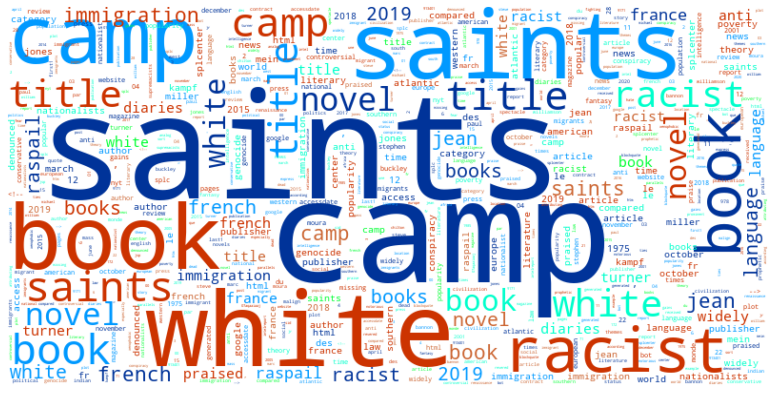

**Select one string you are interested in:**

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

In [55]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Word Cloud' BUTTON ###
### -------------------------------------------------------------------------- ###

wc_action_listener = WCActionsListener(sources={
            "tokens_source": sources,
            "tokens_inc_stop": actions_inc_stop
        }, lng=abbreviation(languageSelection.value))

wc_con_listener = WCListener(sources={"tokens_source": sources}, lng=abbreviation(languageSelection.value))

# Parameters
date_start = date(2005, 3, 22)
date_end = date(2021, 2, 7)
action_type = 'All'  #'All', 'adds', 'adds_48h', 'dels', 'dels_48h', 'reins', 'reins_48h'
stopwords = "Not included" # 'included', 'Not included'

# conflict tokens visualization
source = 'All Actions' #'All Actions', 'Elegible Actions', 'Only Conflicts'
conflict_action = 'Both' #'Both', 'Just Insertions', 'Just Deletions'
editor='All'

wc_action_listener.listen(_range1 = date_start, _range2 = date_end, action = action_type, stopwords = stopwords)

# Uncomment this to plot the word cloud for conflicts        
# wc_con_listener.listen(
#                  _range1 = date_start,
#                  _range2 = date_end,
#                  source = source,
#                  action = conflict_action,
#                  editor = editor,
#                  stopwords = stopwords)

---
## B.3 Token-level conflicts - Conflict scores of individual change actions

In the following table, all the actions that are in conflict are presented, and a conflict score
is presented per action. The importance of the conflict can be meassure by considering the seconds t that 
have passed since the last action on the same token (string) has occured (`time_diff_secs` column). A score to 
meassure conflict is calculated based on t with the following formula: 1 / log<sub>3600</sub>(t+2). 
Thus, *undo* actions are weighted higher than the original time in seconds when the *t* is less than an hour.
For details, please refer to [Flöck et al, 2017](https://arxiv.org/abs/1703.08244).

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **string**: the string of the token that is being tracked
- **order**: numerical variable, shows the order of the conflicting actions in the revision history
- **count**: numerical indicator of how often a given token is in the revision history
- **token_id**: the id of the token that is being tracked
- **rev_id**: the revision id in which the action (insertion or deletion) happen
- **editor_name**: the name of an editor that performed an action
- **editor_id**: the id of the editor that inserted the token (if starts with **0|**, it means that
the editor is not registered, and the ip is displayed instead
- **time_diff_secs**: seconds that have passed since the last action on the same token has occured
- **conflict**: a score to meassure conflict that is calculated based on the `time_diff_secs` 
with the following formula: *1 / log<sub>3600</sub>(time_diff_secs + 2)*. For details, please refer to 
[Flöck et al, 2017](https://arxiv.org/abs/1703.08244)

<mark> *Question: Should explain -1 in the rev_id column?* </mark>
</details>

In [22]:
# create and display the button
button2 = widgets.Button(description="Show Conflict Score of Each Action", layout=Layout(width='250px'))
display(button2)

def on_click_actions(b):
    global conflictaction_listener
    with out9:
        clear_output()
        
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        datepicker_from = widgets.DatePicker(description='Date starts', value=pd.to_datetime(revisions['rev_time'].iloc[0]), layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=pd.to_datetime(revisions['rev_time'].iloc[-1]), layout=Layout(width='25%'))
        
        conflictaction_listener = ConflictsActionListener(sources={
            "tokens_source": sources,
            "Editors": editors,
            "Revisions": revisions
        },lng=abbreviation(languageSelection.value))
               
        stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
        interact(conflictaction_listener.listen_to_interact, _range1 = datepicker_from, _range2 = datepicker_to, stopwords = stopwords)

                      
out9 = Output()
display(out9)

# set the event
button2.on_click(on_click_actions)

# trigger the event with the default value
on_click_actions(button2)

Button(description='Show Conflict Score of Each Action', layout=Layout(width='250px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Conflict Score of Each Action' button: </span>

In [23]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### --------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Conflict Score of Each Action' BUTTON   ###
### --------------------------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

## Create a ConflictsActionListener instance, more details see: ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/conflicts_listener.py#L178 ##
# conflict_actions = ConflictsActionListener(sources={
#             "tokens_source": token_sources,
#             "Editors": grabbed_names,
#             "Revisions": all_revisions
#         },lng=abbreviation(languageSelection.value))

## Visualization ##
begin_date = date(2007, 3, 1)
end_date = date(2020, 5, 1)
include_stopwords = "Not included"  # "Not inclueded", "Included"
revisionID = "706448515"  # Any revision id from rev_id column

conflictaction_listener.listen(begin_date, end_date, include_stopwords)
print(f"Link to the wikipedia diff: https://{conflictaction_listener.lng}.wikipedia.org/w/index.php?&title={the_page['title'].replace(' ', '_')}&diff={revisionID}")

---
# C. Talk

## C.1 Talk frequency - How are revisions in the talk section distributed over time?

The Talk page activity represents the number of revisions on the Talk page of the Wikipedia article extracted by WikiWho API. 

In the controls you can select the *date range* and the *granularity*

In [24]:
button_t = widgets.Button(description="Load Talks", layout=Layout(width='160px'))
display(button_t)

def on_click_details(b):
    global talk_content 
    with out_t:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))

        #Initiate a Wikipedia instance
        wikipediadv_instance = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
        
        #Get content of revisions on talk page
        talk_content = wikipediadv_instance.get_talk_content(the_talk_page["page_id"])
        
        #convert to datetime format
        talk_content['year_month'] = pd.to_datetime(talk_content['timestamp'])

        
        # Define a TalksListener instance
        talks_listener = TalksListener(talk_content)

        # Visualization
        datepicker_from = widgets.DatePicker(description='Date starts', value=talk_content['year_month'].iloc[-1], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=talk_content['year_month'].iloc[0], layout=Layout(width='25%'))

        interact(talks_listener.listen,
            begin = datepicker_from,
            end = datepicker_to,
            granularity = Dropdown(options=['Monthly', 'Yearly', 'Daily'], value='Monthly')
        )

out_t = Output()
display(out_t)

# set the event
button_t.on_click(on_click_details)

# trigger the event with the default value
on_click_details(button_t)

Button(description='Load Talks', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Talks' button: </span>

In [25]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Load Talks' BUTTON  ###
### -------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_talk_page['title'])

# Initiate a Wikipedia instance
wikipediadv_instance = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))

# Get content of revisions on talk page
# more details see: https://github.com/gesiscss/wikiwho_demo_new/blob/master/external/wikipedia.py#L109
talk_content = wikipediadv_instance.get_talk_content(the_talk_page["page_id"])

# convert to datetime format
talk_content['year_month'] = pd.to_datetime(talk_content['timestamp'])

## Define a TalksListener instance ##
# more details see: https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/talks_listener.py
talks_listener = TalksListener(talk_content)

## Visualization ##
begin_date = date(2005, 3, 1)
end_date = date(2015, 7, 4)
granularity = 'Monthly'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
talks_listener.listen(
    begin = begin_date,
    end = end_date,
    granularity = granularity)

## C.2 Talk topics - What are talk entries about?

It is also possible to review what are the talks about by subsections, under which revisions happened. The table below shows the topic of each revision, sorted by date. Although most of the times users change the content of the talk page, sometimes revisions include actions like signing a comment, deleting or reversing revisions. These actions are not presented in the table.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **topic**: the string topic extracted from revision content
- **revid**: the revision id in which the action happened
- **user**: the id or ip address of the editor that inserted the token
- **year_month**: timestamp when the revision took place
- **action_type**: type of the action made in a revision (new topic added or topic edited)

</details>

The graph illustrates revisions by topics spread over time.

In the controls for the graph you can select the *date range* and the *granularity*

In [26]:
button_to = widgets.Button(description="Load Topics", layout=Layout(width='160px'))
display(button_to)

def on_click_topics(b):
    global topics_listener, topic_df
    with out_to:
        clear_output()
        display(md(f"***Page: {the_talk_page['title']} ({abbreviation(languageSelection.value).upper()})***"))

        topics_listener = TopicsListener(talk_content)

        #get a dataframe with topics and action_types
        wikipediadv_ins = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
        topic_df = topics_listener.extract_topics(wikipediadv_ins)
        
                   
        #adding transcluded content
        tr_row = talk_content[talk_content['comment'].str.match(r'Transcluding GA review')==True]
        if len(tr_row)>0:
            wikipedia_dv = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
            transcluded_page = wikipedia_dv.get_page(the_talk_page['title'] +'/GA1')
            transcluded_talk_content = wikipedia_dv.get_talk_content(transcluded_page["page_id"])
            transcluded_talk_content['year_month'] = pd.to_datetime(transcluded_talk_content['timestamp'])
            tr_topics_listener = TopicsListener(transcluded_talk_content)
            transcluded_topic_df = tr_topics_listener.translusion(wikipedia_dv).set_index('topics')
            topics_listener.topic_df = topic_df.append(transcluded_topic_df).sort_values(by='year_month', ascending = False)
        if len(topic_df) == 0:
            display(md("There is no topics here!"))
        else:        
            display(qgrid.show_grid(topics_listener.topic_df))

            # Visualization
            datepicker_from = widgets.DatePicker(description='Date starts', value=talk_content['year_month'].iloc[-1], layout=Layout(width='25%'))
            datepicker_to = widgets.DatePicker(description='Date ends', value=talk_content['year_month'].iloc[0], layout=Layout(width='25%'))

            interact(topics_listener.listen,
                begin = datepicker_from,
                end = datepicker_to,
                granularity = Dropdown(options=['Monthly', 'Yearly', 'Daily'], value='Monthly')
            )

out_to = Output()
display(out_to)

# set the event
button_to.on_click(on_click_topics)

# trigger the event with the default value
on_click_topics(button_to)

Button(description='Load Topics', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Topics' button: </span>

In [27]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### --------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Topics' BUTTON  ###
### --------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_talk_page['title'])
print(f"Time range from {talk_content['year_month'].iloc[-1].date()} to {talk_content['year_month'].iloc[0].date()}")

## Initiate a topics listener, more details see:                                             ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/topics_listener.py ##
topics_listener = TopicsListener(talk_content)

# Get a dataframe with topics and action_types
wikipediadv_ins = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
topic_df = topics_listener.extract_topics(wikipediadv_ins)
if len(topic_df) == 0:
    print("There is no topics here!")
else:
    display(qgrid.show_grid(topic_df))

    # Visualization
    begin_date = talk_content['year_month'].iloc[-1]  # date(xxxx.xx.xx)
    end_date = talk_content['year_month'].iloc[0]  # date(xxxx.xx.xx)
    granularity = 'Monthly'

    topics_listener.listen(
        begin = begin_date,
        end = end_date,
        granularity = granularity)

In [28]:
lng_selected = abbreviation(languageSelection.value)
#calculator = con_manager
%store agg_actions
#%store calculator
#%store editors_conflicts
%store lng_selected
%store sources
%store con_manager_all

clear_output()
display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
# if len(editors_conflicts) > 0:
#     display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
# else:
#     display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))

re_hide = """
<script>
var update_input_visibility = function () {
    Jupyter.notebook.get_cells().forEach(function(cell) {
        if (cell.metadata.hide_input) {
            cell.element.find("div.input").hide();
        }
    })
};
update_input_visibility();
</script
"""
display(HTML(re_hide))

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script>
"""

display(HTML(scroll_to_top))

TypeError: 'NoneType' object is not subscriptable